In [3]:
import json

with open('dataset/LPI12 dataset.json', 'r') as f:
        TrainData = json.load(f)

In [4]:
import models._config as c

from dataset.RadarDataset import RadarSignalDataset

train_dataset = RadarSignalDataset(TrainData, c.signalTypes[0:c.typeSize], snr_max=2)


Data loading for 'Barker'.Done!
Data loading for 'Costas'.Done!
Data loading for 'Frank'.Done!
Data loading for 'LFM'.Done!
Data loading for 'P1'.Done!
Data loading for 'P2'.Done!
Data loading for 'P3'.Done!
Data loading for 'P4'.Done!
Data loading for 'T1'.Done!
Data loading for 'T2'.Done!
Data loading for 'T3'.Done!
Data loading for 'T4'.Done!


In [1]:
import torch
import torch.nn.functional as F

class LRP:
    def __init__(self, model, epsilon=1e-6):
        self.model = model
        self.epsilon = epsilon

    def get_relevance(self, x, lengths, target=None):
        """
        주어진 입력에 대해 Relevance를 계산합니다.
        x: 입력 시퀀스 [batch_size, seq_len, input_size]
        lengths: 각 시퀀스의 길이 [batch_size]
        target: 예측된 클래스를 지정하는 옵션 (지정되지 않으면 모델이 예측한 클래스를 사용)
        """
        # 모델의 출력과 hidden state 가져오기
        output, hidden_states, attn_weights = self.model(x, lengths, lstm_outputs=True)

        if target is None:
            target = torch.argmax(output, dim=1)  # 예측된 클래스 선택

        # 출력의 Relevance 초기화
        relevance = torch.zeros_like(output)
        for i in range(output.size(0)):
            relevance[i, target[i]] = output[i, target[i]]

        # LRP 역전파 (hidden states에 relevance 분배)
        relevance = self.compute_relevance(hidden_states, relevance, attn_weights)
        return relevance

    def compute_relevance(self, hidden_states, relevance, attn_weights):
        """
        LRP 역전파를 사용하여 hidden states에 Relevance 분배
        hidden_states: [batch_size, seq_len, hidden_size * 2]
        relevance: [batch_size, num_classes]
        attn_weights: [batch_size, seq_len]
        """
        batch_size, seq_len, hidden_size = hidden_states.size()

        # Relevance 초기화
        relevance_h = torch.zeros_like(hidden_states)

        # Relevance를 Attention 가중치에 따라 각 타임스텝에 분배
        for i in range(batch_size):
            # Attention에 의해 각 타임스텝에 가중치 적용
            relevance_t = relevance[i].unsqueeze(0).expand(seq_len, -1) * attn_weights[i].unsqueeze(-1)
            relevance_h[i] = torch.sum(hidden_states[i] * relevance_t, dim=-1)

        return relevance_h


In [18]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from models.LSTM import BiLSTM
from explainer import LRP  # LRP 클래스가 들어있는 모듈



def explain_set(train_dataset):
    """
    주어진 데이터셋에 대해 모델의 Relevance를 설명하고 시각화합니다.
    """
    # 모델 로드 및 설정
    model = BiLSTM(input_size=2, hidden_size=128, num_layers=2, num_classes=12)
    model.load_state_dict(torch.load('/home/kiwan/TSC_XAI/ckpts/ 0dB/LSTM_ 0dB_0.0073.pt'))
    model.eval()
    lrp = LRP(model)

    batch = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=model.collate)

    # 그래프 설정
    fig = plt.figure(figsize=(20, 15))

    # 데이터셋에서 배치 가져오기
    with torch.no_grad():
        for data_batch, labels, snr, lengths in batch:
            for i in range(len(data_batch)):
                data = data_batch[i].unsqueeze(0)  # 하나의 샘플만 가져오기
                seq_len = torch.tensor([len(data_batch[i])], dtype=torch.int64).cpu()

                # LRP로 Relevance 스코어 계산
                r_scores = lrp.get_relevance(data, seq_len)

                # 실제 신호와 Relevance 시각화
                real_part = data_batch[i][:, 0].cpu().numpy()  # 실수부
                imag_part = data_batch[i][:, 1].cpu().numpy()  # 허수부
                r_scores_real = r_scores[:, 0].cpu().numpy()   # Relevance 실수부

                # 그래프 그리기
                ax = fig.add_subplot(4, 2, i + 1)
                ax.plot(real_part, label='Real Part')
                ax.plot(r_scores_real, label='Relevance (Real Part)', linestyle='--')
                ax.set_title(f'Sample {i+1} (SNR: {snr[i]} dB)')
                ax.legend()

            break  # 첫 번째 배치만 시각화

    # 그래프 레이아웃 정리 및 표시
    plt.tight_layout()
    plt.show()

explain_set(train_dataset)

tensor([[1078]])


RuntimeError: 'lengths' argument should be a 1D CPU int64 tensor, but got 0D cpu Long tensor

<Figure size 2000x1500 with 0 Axes>

1008 1008


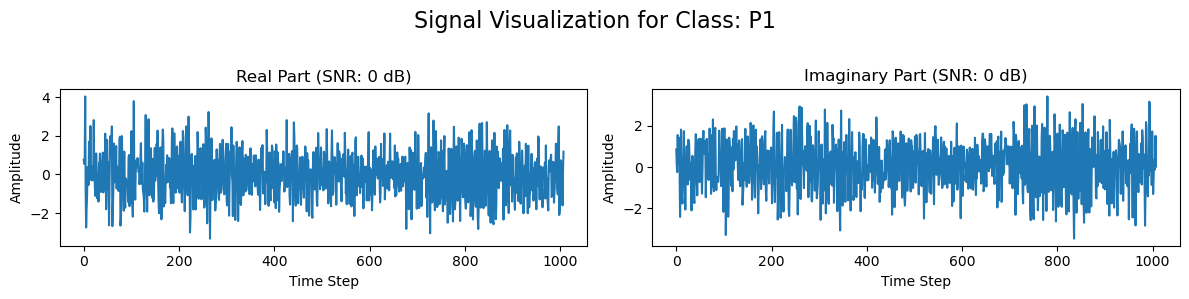

1344 1344


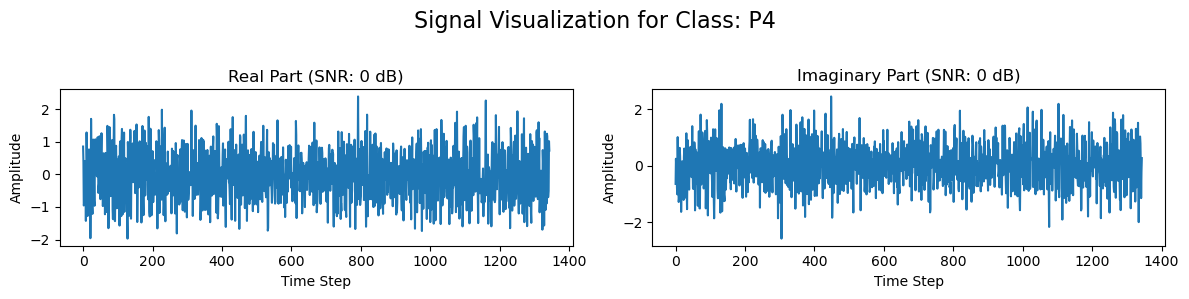

635 635


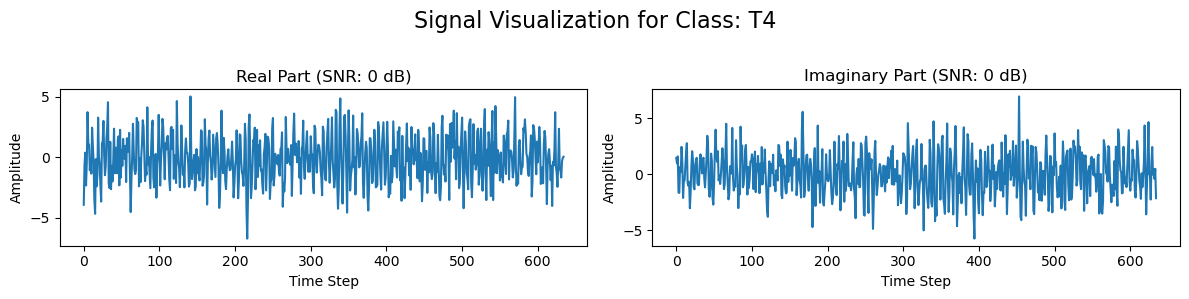

972 972


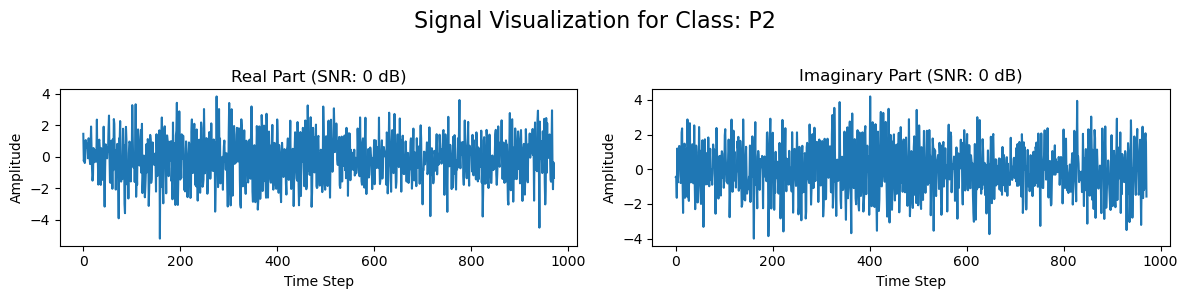

1127 1127


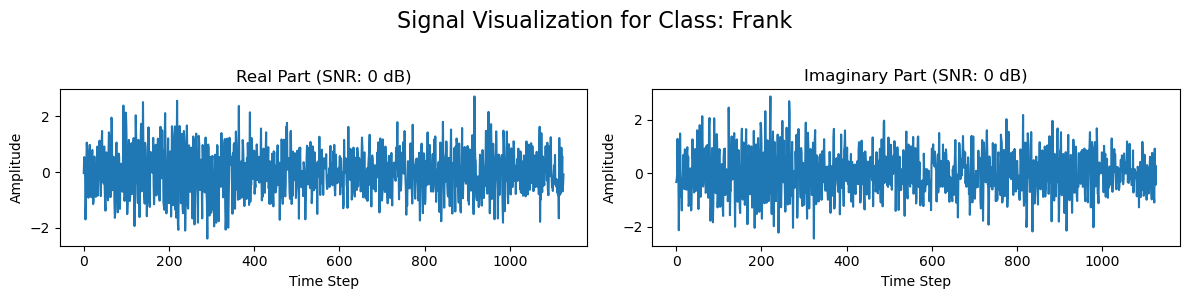

1078 1078


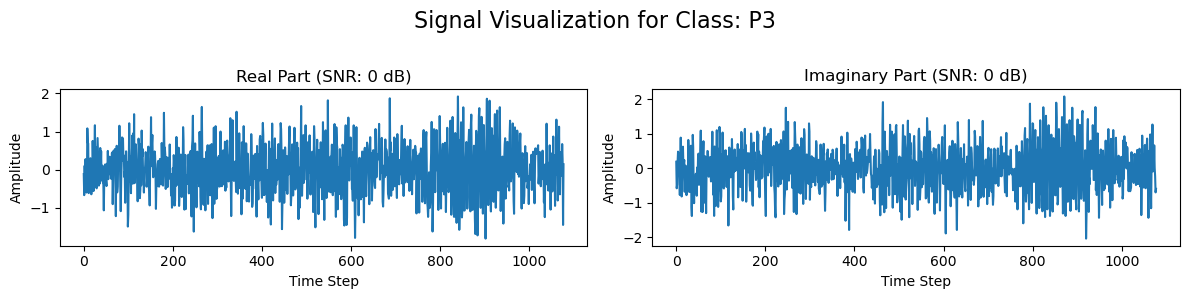

275 275


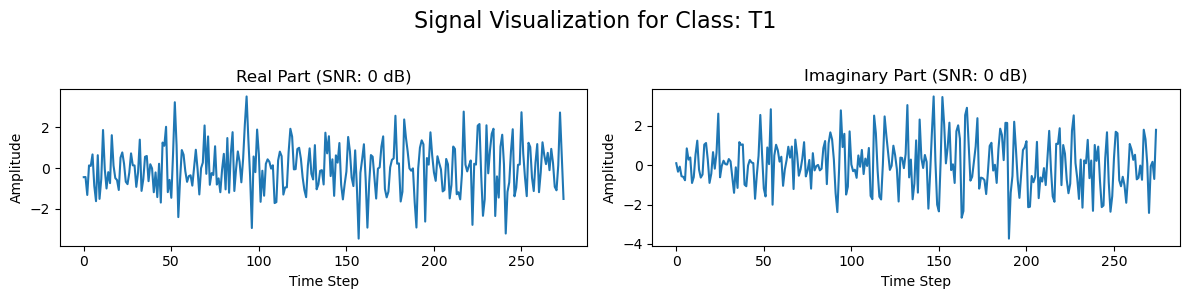

1063 1063


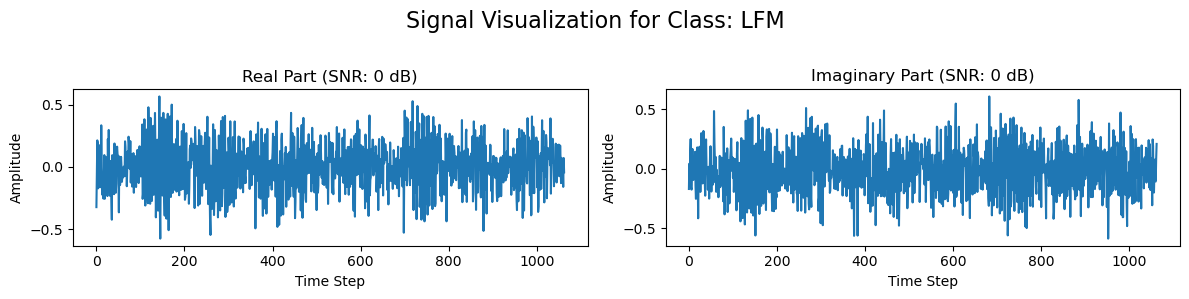

1233 1233


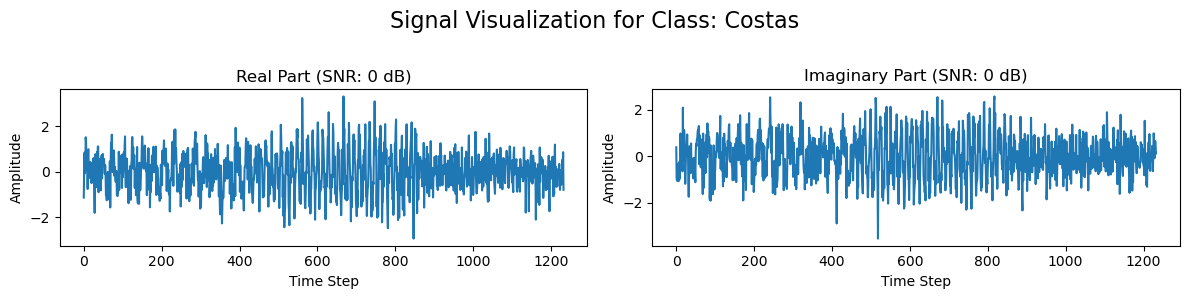

165 165


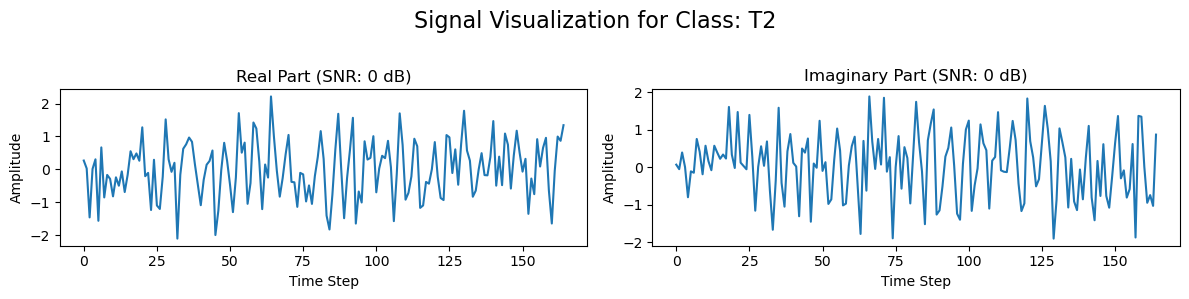

747 747


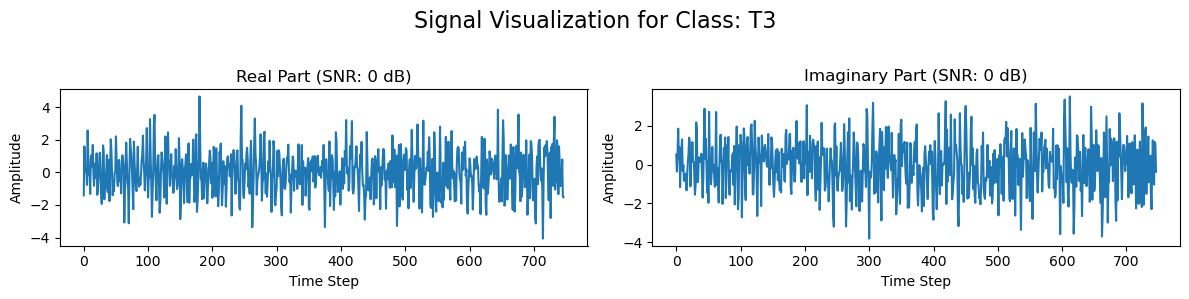

770 770


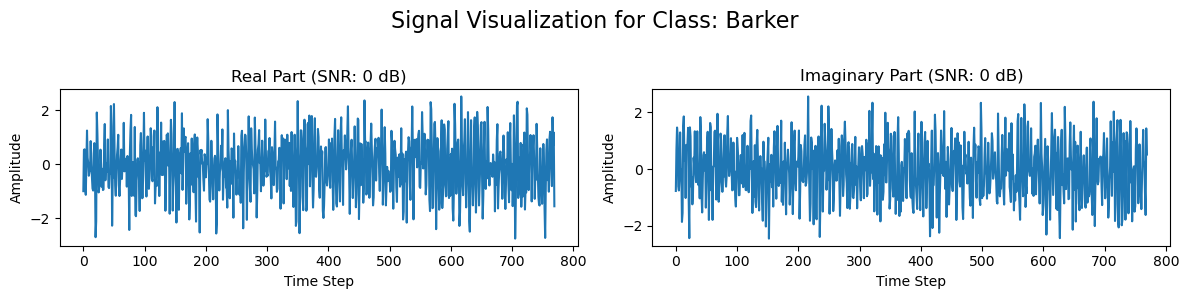

In [39]:


samples_per_class = 1

class_samples = {signal_type: [] for signal_type in set(train_dataset.labels)}

for idx in range(len(train_dataset)):
    _, label, _, _ = train_dataset[idx]
    if len(class_samples[label]) < samples_per_class:
        class_samples[label].append(idx)

    if all(len(samples) == samples_per_class for samples in class_samples.values()):
        break

for label, indices in class_samples.items():
    fig, axes = plt.subplots(len(indices), 2, figsize=(12, 3 * len(indices)))
    fig.suptitle(f'Signal Visualization for Class: {label}', fontsize=16)

    for i, idx in enumerate(indices):
        data_sample, _, snr, length = train_dataset[idx]
        
        print(len(data_sample), length)
        # 실수부와 허수부 추출
        real_part = [point[0] for point in data_sample]
        imag_part = [point[1] for point in data_sample]
        
        axes[0].plot(real_part)
        axes[0].set_title(f'Real Part (SNR: {snr} dB)')
        axes[0].set_xlabel('Time Step')
        axes[0].set_ylabel('Amplitude')

        axes[1].plot(imag_part)
        axes[1].set_title(f'Imaginary Part (SNR: {snr} dB)')
        axes[1].set_xlabel('Time Step')
        axes[1].set_ylabel('Amplitude')


    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(f'./dataset/imgs/signal_visualization_class_{label}.png')
    plt.show()